# Proyecto XAI 
## Clasificación de Imágenes Reales vs Generadas por IA

Este notebook implementa un clasificador de redes neuronales convolucionales para distinguir entre imágenes reales y generadas por IA.

In [ ]:
os.environ['KAGGLE_USERNAME'] = os.getenv('KAGGLE_USERNAME')
os.environ['KAGGLE_KEY'] = os.getenv('KAGGLE_KEY')
!kaggle datasets download birdy654/cifake-real-and-ai-generated-synthetic-images
!unzip cifake-real-and-ai-generated-synthetic-images.zip

## 1. Importar bibliotecas necesarias

In [5]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, metrics
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess
from tensorflow.keras.utils import image_dataset_from_directory, array_to_img
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tqdm as tqdm

# Lime|
from lime import lime_image 
from skimage.segmentation import mark_boundaries

# Comprobar si estamos usando GPU
print(tf.config.list_physical_devices('GPU'))
!nvidia-smi

# Configurar semilla aleatoria para reproducibilidad
tf.random.set_seed(42)
np.random.seed(42)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Sun Jun 29 18:01:07 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.57.04              Driver Version: 576.52         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 Ti     On  |   00000000:08:00.0  On |                  N/A |
|  0%   41C    P8             16W /  200W |     969MiB /   8192MiB |      7%      Default |
|                                         |                        |     

## 2. Definir variables globales

In [6]:
FILE_PATH = '../dataset'
IMG_SIZE = 224
BATCH_SIZE = 64

## 3. Cargar y preparar los datos

In [7]:
# Se aplica la preprocesacion especifica de VGG16
def adapt_image_for_vgg16(image, label):
    image = vgg_preprocess(image)
    return image, label


train_path = os.path.join(FILE_PATH, 'train')
# Se crea el dataset de entrenamiento a partir del directorio
train_dataset = image_dataset_from_directory(
    train_path,
    labels='inferred',           # Infiere las etiquetas a partir de los nombres de las carpetas
    label_mode='binary',         
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    validation_split=0.2,        
    subset='training'            
)

# Se crea el dataset de validacion a partir del mismo directorio
validation_dataset = image_dataset_from_directory(
    train_path,
    labels='inferred',
    label_mode='binary',
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False,               
    validation_split=0.2,
    subset='validation'
)

# Aplicar la preprocesacion de VGG16 a los datasets
# Usamos num_parallel_calls=tf.data.AUTOTUNE para optimizar el rendimiento
train_dataset = train_dataset.map(adapt_image_for_vgg16, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.map(adapt_image_for_vgg16, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

Found 100000 files belonging to 2 classes.
Using 80000 files for training.


I0000 00:00:1751234476.284203    3060 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5592 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:08:00.0, compute capability: 8.6


Found 100000 files belonging to 2 classes.
Using 20000 files for validation.


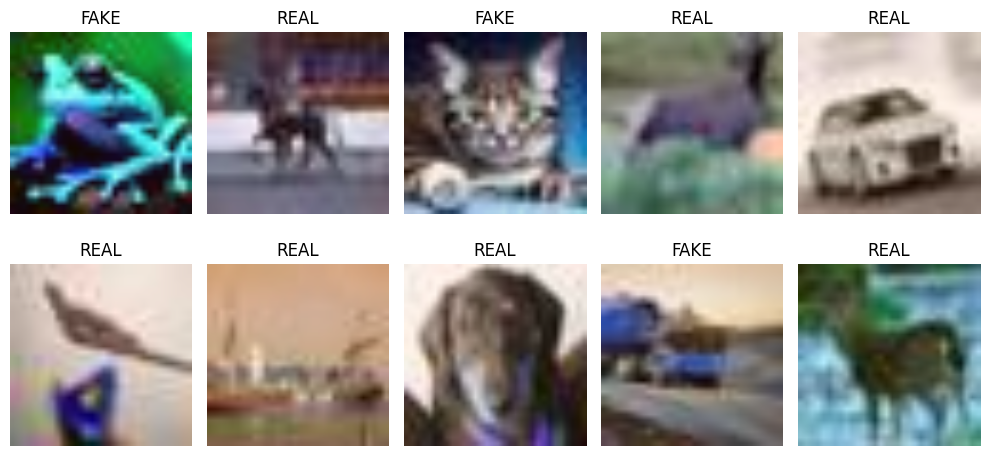

In [6]:
# Visualizar algunas imágenes de ejemplo
sample_size = 10
sample_images, sample_labels = [], []
for images, labels in train_dataset.take(1):  # Tomar solo un lote
    for i in range(min(sample_size, len(images))):
        sample_images.append(tf.keras.utils.array_to_img(images[i]))
        sample_labels.append(labels[i].numpy())

# Visualizar imágenes de muestra
plt.figure(figsize=(10, 5))
for i in range(len(sample_images)):
    plt.subplot(2, 5, i+1)
    plt.imshow(sample_images[i])
    class_name = ['FAKE', 'REAL'][int(sample_labels[i][0])]
    plt.title(class_name)
    plt.axis('off')
plt.tight_layout()
plt.show()

## 4. Definir arquitectura del modelo

### Modelo Propio


In [8]:
# Definir el modelo
input_shape = (IMG_SIZE, IMG_SIZE, 3)

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

model = models.Sequential([
    layers.Input(input_shape),
    data_augmentation,
    layers.Conv2D(64, kernel_size=3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D(4),
    layers.Dropout(0.1),
    layers.Conv2D(128, kernel_size=3, padding='same', activation='relu', name='last_conv_layer'),
    layers.BatchNormalization(),
    layers.MaxPool2D(4),
    layers.Dropout(0.1),
    layers.Flatten(),
    layers.Dense(64, activation='relu', name='output_layer'),
    layers.Dense(1, activation='sigmoid')
])

# Compilar el modelo
model.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy', metrics.F1Score(threshold=0.5)]
)

# Imprimir resumen del modelo
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ last_conv_layer (Conv2D)        │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,682,177 (6.42 MB)

 Trainable params: 1,681,793 (6.42 MB)

 Non-trainable params: 384 (1.50 KB)

In [9]:
# Callback de early stopping
es_callback = tf.keras.callbacks.EarlyStopping(
    patience=10,
    verbose=1,
    restore_best_weights=True
)


# Checkpoint del modelo para guardar el mejor modelo
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'CIFAKE.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

In [10]:
# Entrenar el modelo
history = model.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    epochs=100,
    callbacks=[es_callback, checkpoint],
    validation_data=validation_dataset,
    verbose=1
)

Epoch 1/100


E0000 00:00:1750914970.665414    1053 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.7350 - f1_score: 0.7491 - loss: 0.7629
Epoch 1: val_accuracy improved from -inf to 0.92095, saving model to CIFAKE.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 219s 171ms/step - accuracy: 0.7351 - f1_score: 0.7491 - loss: 0.7627 - val_accuracy: 0.9209 - val_f1_score: 0.9588 - val_loss: 0.2245
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.8600 - f1_score: 0.8603 - loss: 0.3234
Epoch 2: val_accuracy did not improve from 0.92095
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 214s 171ms/step - accuracy: 0.8600 - f1_score: 0.8603 - loss: 0.3234 - val_accuracy: 0.9093 - val_f1_score: 0.9525 - val_loss: 0.2245
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.8901 - f1_score: 0.8896 - loss: 0.2628
Epoch 3: val_accuracy did not improve from 0.92095
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 214s 171ms/step - accuracy: 0.8901 - f1_score: 0.8896 - loss: 0.2628 - val_accuracy: 0.8953 - val_f1_score: 0.9448 - val_loss: 0.2577
Epo

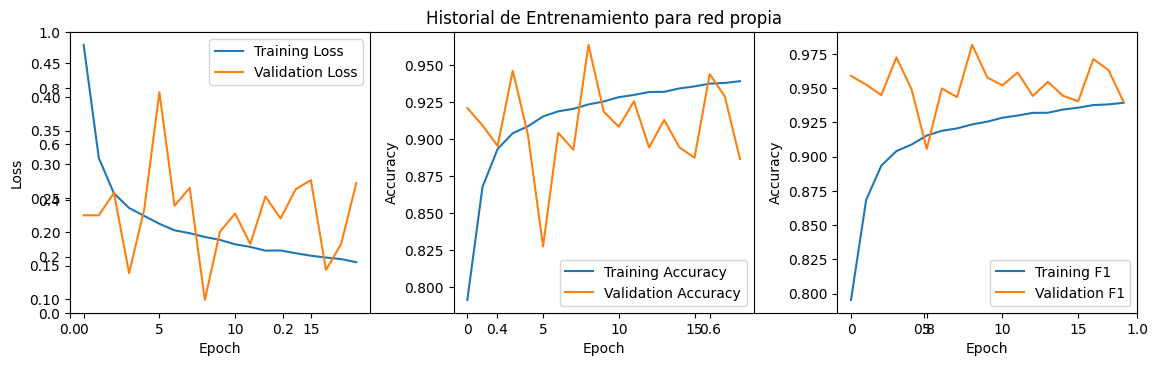

In [11]:
# Graficar historial de entrenamiento
plt.figure(figsize=(12, 4))
plt.title('Historial de Entrenamiento para red propia')

# Loss
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')   
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# F1
plt.subplot(1, 3, 3)
plt.plot(history.history['f1_score'], label='Training F1')
plt.plot(history.history['val_f1_score'], label='Validation F1')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('historial_entrenamiento.png')
plt.show()

### VGG16

In [45]:
# Utilizar transfer learning con VGG16
from tensorflow.keras.applications import VGG16

# Aumentación de datos
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Aplicar aumentación de datos
x = layers.RandomFlip("horizontal")(inputs)
x = layers.RandomRotation(0.1)(x)
x = layers.RandomZoom(0.1)(x)

base_model = VGG16(weights='imagenet', include_top=False, input_tensor=x)

# Congelar las capas de la base para evitar que se entrenen
for layer in base_model.layers:
    layer.trainable = False

# Utilizar la salida de la base como entrada para nuevas capas
feature_batch = base_model.output
x = layers.Flatten()(feature_batch)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
predictions = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs=inputs, outputs=predictions)

# Compilar el modelo
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', metrics.F1Score(threshold=0.5)]
)

# Imprimir resumen del modelo
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [46]:
# Callback de early stopping
es_callback = tf.keras.callbacks.EarlyStopping(
    patience=5,
    verbose=1,
    restore_best_weights=True
)

# Checkpoint del modelo para guardar el mejor modelo
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    #'CIFAKE.keras',
    'VGG_CIFAKE.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

In [47]:
# Entrenar el modelo
history = model.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    epochs=30,
    callbacks=[es_callback, checkpoint],
    validation_data=validation_dataset,
    verbose=1
)

Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.8382 - f1_score: 0.8320 - loss: 1.0005
Epoch 1: val_accuracy improved from -inf to 0.93805, saving model to VGG_CIFAKE.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 239s 189ms/step - accuracy: 0.8383 - f1_score: 0.8321 - loss: 1.0000 - val_accuracy: 0.9380 - val_f1_score: 0.9680 - val_loss: 0.1625
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9100 - f1_score: 0.9098 - loss: 0.2270
Epoch 2: val_accuracy did not improve from 0.93805
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 230s 184ms/step - accuracy: 0.9100 - f1_score: 0.9098 - loss: 0.2270 - val_accuracy: 0.9345 - val_f1_score: 0.9661 - val_loss: 0.1748
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9170 - f1_score: 0.9173 - loss: 0.2071
Epoch 3: val_accuracy improved from 0.93805 to 0.95925, saving model to VGG_CIFAKE.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 233s 186ms/step - accuracy: 0.9170 - f1_score: 0.9173 - loss: 0.2071 - val_accuracy: 0

In [48]:
# Fine Tuning

# Descongelamos el ultimo bloque de capas convolucionales
for layer in base_model.layers[-4:]:
    layer.trainable = True

for layer in model.layers:
  if layer.trainable:
    print(f"{layer.name}: Trainable = {layer.trainable}")

# Compilamos el modelo con un learning rate bajo para evitar grandes cambios en los pesos
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy', metrics.F1Score(threshold=0.5)]
)

history_unfrozen = model.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    epochs=30,
    callbacks=[es_callback, checkpoint],
    validation_data=validation_dataset,
    verbose=1
)

block5_conv1: Trainable = True
block5_conv2: Trainable = True
block5_conv3: Trainable = True
block5_pool: Trainable = True
flatten: Trainable = True
flatten_1: Trainable = True
dense: Trainable = True
dropout: Trainable = True
dense_1: Trainable = True
Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9454 - f1_score: 0.9459 - loss: 0.1443
Epoch 1: val_accuracy improved from 0.97625 to 0.98325, saving model to VGG_CIFAKE.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 223s 177ms/step - accuracy: 0.9454 - f1_score: 0.9459 - loss: 0.1442 - val_accuracy: 0.9833 - val_f1_score: 0.9916 - val_loss: 0.0578
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9540 - f1_score: 0.9543 - loss: 0.1193
Epoch 2: val_accuracy did not improve from 0.98325
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 222s 177ms/step - accuracy: 0.9540 - f1_score: 0.9543 - loss: 0.1193 - val_accuracy: 0.9793 - val_f1_score: 0.9895 - val_loss: 0.0680
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - a

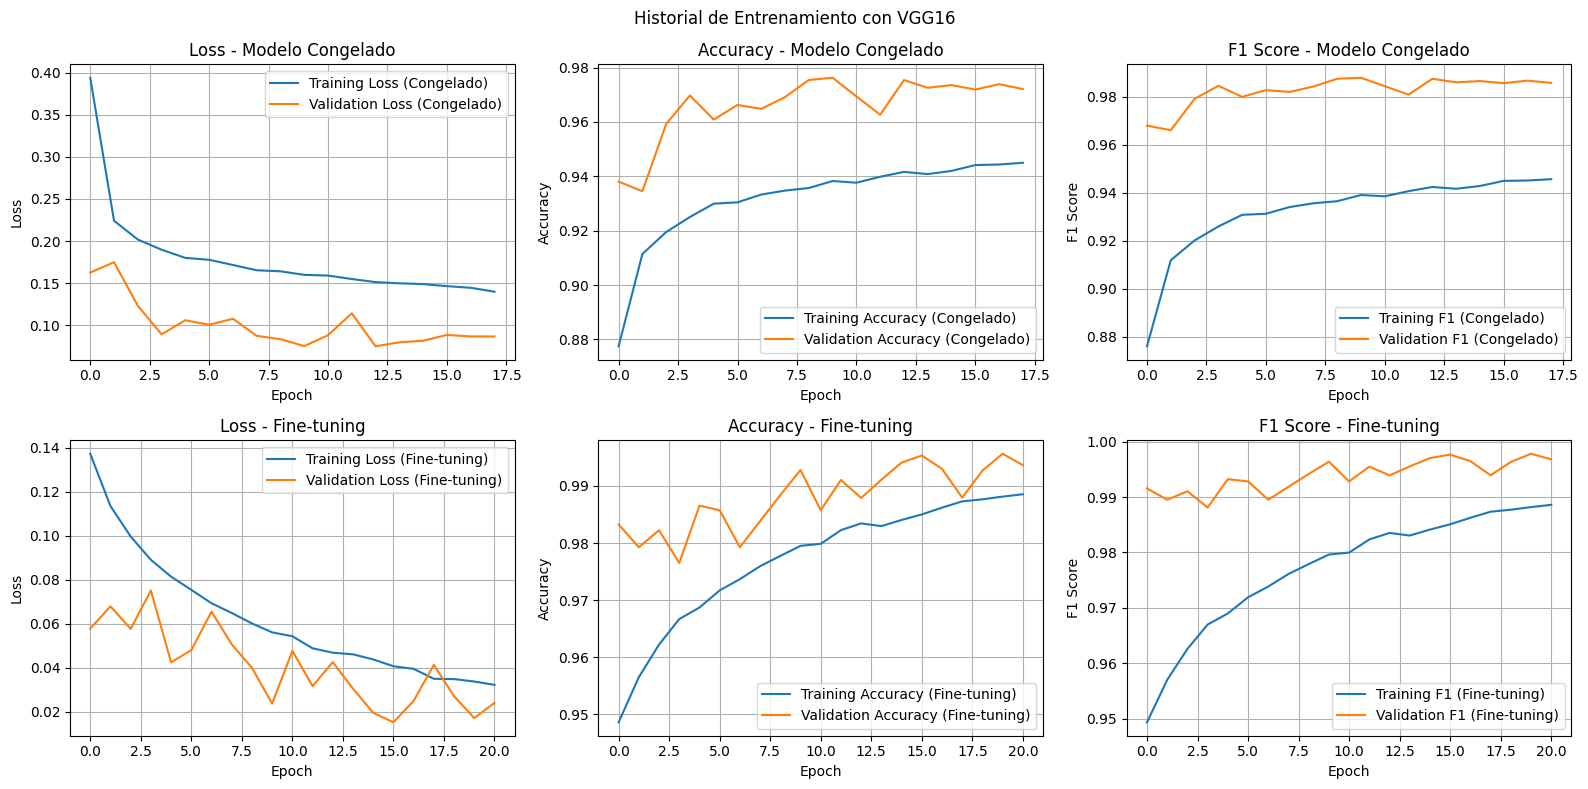

In [49]:
# Graficar historial de entrenamiento
plt.figure(figsize=(16, 8))
plt.suptitle('Historial de Entrenamiento con VGG16')

# Primera fila: Entrenamiento con VGG16 Congelado
# Loss 
plt.subplot(2, 3, 1) 
plt.plot(history.history['loss'], label='Training Loss (Congelado)')
plt.plot(history.history['val_loss'], label='Validation Loss (Congelado)')
plt.title('Loss - Modelo Congelado')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(2, 3, 2) 
plt.plot(history.history['accuracy'], label='Training Accuracy (Congelado)')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy (Congelado)')
plt.title('Accuracy - Modelo Congelado')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# F1 Score 
plt.subplot(2, 3, 3) 
plt.plot(history.history['f1_score'], label='Training F1 (Congelado)')
plt.plot(history.history['val_f1_score'], label='Validation F1 (Congelado)')
plt.title('F1 Score - Modelo Congelado')
plt.xlabel('Epoch')
plt.ylabel('F1 Score') 
plt.legend()
plt.grid(True)

# Segunda fila: Entrenamiento con VGG16 Descongelado

# Loss 
plt.subplot(2, 3, 4) 
plt.plot(history_unfrozen.history['loss'], label='Training Loss (Fine-tuning)')
plt.plot(history_unfrozen.history['val_loss'], label='Validation Loss (Fine-tuning)')
plt.title('Loss - Fine-tuning')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy 
plt.subplot(2, 3, 5) 
plt.plot(history_unfrozen.history['accuracy'], label='Training Accuracy (Fine-tuning)')
plt.plot(history_unfrozen.history['val_accuracy'], label='Validation Accuracy (Fine-tuning)')
plt.title('Accuracy - Fine-tuning')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# F1 Score 
plt.subplot(2, 3, 6) 
plt.plot(history_unfrozen.history['f1_score'], label='Training F1 (Fine-tuning)')
plt.plot(history_unfrozen.history['val_f1_score'], label='Validation F1 (Fine-tuning)')
plt.title('F1 Score - Fine-tuning')
plt.xlabel('Epoch')
plt.ylabel('F1 Score') 
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('historial_entrenamiento_vgg16_combinado.png')
plt.show()

In [50]:
import pandas as pd
hist_df = pd.DataFrame(history.history)

# --- 3. Guardar el DataFrame en un archivo CSV ---
hist_csv_file = 'historial_entrenamiento_vgg16.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f, index=False) # index=False para no guardar el índice del DataFrame

hist_df = pd.DataFrame(history_unfrozen.history)
hist_csv_file = 'historial_finetuning_vgg16.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f, index=False) # index=False para no guardar el índice del DataFrame

### InceptionV3

In [ ]:
# Utilizar transfer learning con InceptionV3
from tensorflow.keras.applications import InceptionV3

# Aumentación de datos
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Aplicar aumentación de datos
x = layers.RandomFlip("horizontal")(inputs)
x = layers.RandomRotation(0.1)(x)
x = layers.RandomZoom(0.1)(x)

base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=x)

# Congelar las capas de la base para evitar que se entrenen
for layer in base_model.layers:
    layer.trainable = False

# Utilizar la salida de la base como entrada para nuevas capas
feature_batch = base_model.output
x = layers.Flatten()(feature_batch)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
predictions = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs=inputs, outputs=predictions)

# Compilar el modelo
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', metrics.F1Score(threshold=0.5)]
)

# Imprimir resumen del modelo
model.summary()

In [35]:
# Callback de early stopping
es_callback = tf.keras.callbacks.EarlyStopping(
    patience=5,
    verbose=1,
    restore_best_weights=True
)

# Checkpoint del modelo para guardar el mejor modelo
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    #'CIFAKE.keras',
    'INCEPTION_CIFAKE.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

In [36]:
# Entrenar el modelo
history = model.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    epochs=30,
    callbacks=[es_callback, checkpoint],
    validation_data=validation_dataset,
    verbose=1
)

Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.7725 - f1_score: 0.7709 - loss: 1.1601
Epoch 1: val_accuracy improved from -inf to 0.82045, saving model to INCEPTION_CIFAKE.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 146s 112ms/step - accuracy: 0.7725 - f1_score: 0.7710 - loss: 1.1596 - val_accuracy: 0.8205 - val_f1_score: 0.9014 - val_loss: 0.3862
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.8460 - f1_score: 0.8445 - loss: 0.3562
Epoch 2: val_accuracy improved from 0.82045 to 0.82145, saving model to INCEPTION_CIFAKE.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 138s 111ms/step - accuracy: 0.8460 - f1_score: 0.8445 - loss: 0.3562 - val_accuracy: 0.8214 - val_f1_score: 0.9020 - val_loss: 0.3761
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.8563 - f1_score: 0.8554 - loss: 0.3316
Epoch 3: val_accuracy improved from 0.82145 to 0.85320, saving model to INCEPTION_CIFAKE.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 136s 109ms/step - accuracy: 0.856

In [37]:
# Fine Tuning

# Descongelamos 
set_trainable = False
for layer in base_model.layers:
    # Cuando encontramos 'mixed9', empezamos a descongelar
    if layer.name == 'mixed9':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

for layer in model.layers:
  if layer.trainable:
    print(f"{layer.name}: Trainable = {layer.trainable}")

# Compilamos el modelo con un learning rate bajo para evitar grandes cambios en los pesos
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy', metrics.F1Score(threshold=0.5)]
)

history_unfrozen = model.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    epochs=30,
    callbacks=[es_callback, checkpoint],
    validation_data=validation_dataset,
    verbose=1
)

mixed9: Trainable = True
conv2d_183: Trainable = True
batch_normalization_183: Trainable = True
activation_183: Trainable = True
conv2d_180: Trainable = True
conv2d_184: Trainable = True
batch_normalization_180: Trainable = True
batch_normalization_184: Trainable = True
activation_180: Trainable = True
activation_184: Trainable = True
conv2d_181: Trainable = True
conv2d_182: Trainable = True
conv2d_185: Trainable = True
conv2d_186: Trainable = True
average_pooling2d_17: Trainable = True
conv2d_179: Trainable = True
batch_normalization_181: Trainable = True
batch_normalization_182: Trainable = True
batch_normalization_185: Trainable = True
batch_normalization_186: Trainable = True
conv2d_187: Trainable = True
batch_normalization_179: Trainable = True
activation_181: Trainable = True
activation_182: Trainable = True
activation_185: Trainable = True
activation_186: Trainable = True
batch_normalization_187: Trainable = True
activation_179: Trainable = True
mixed9_1: Trainable = True
concat

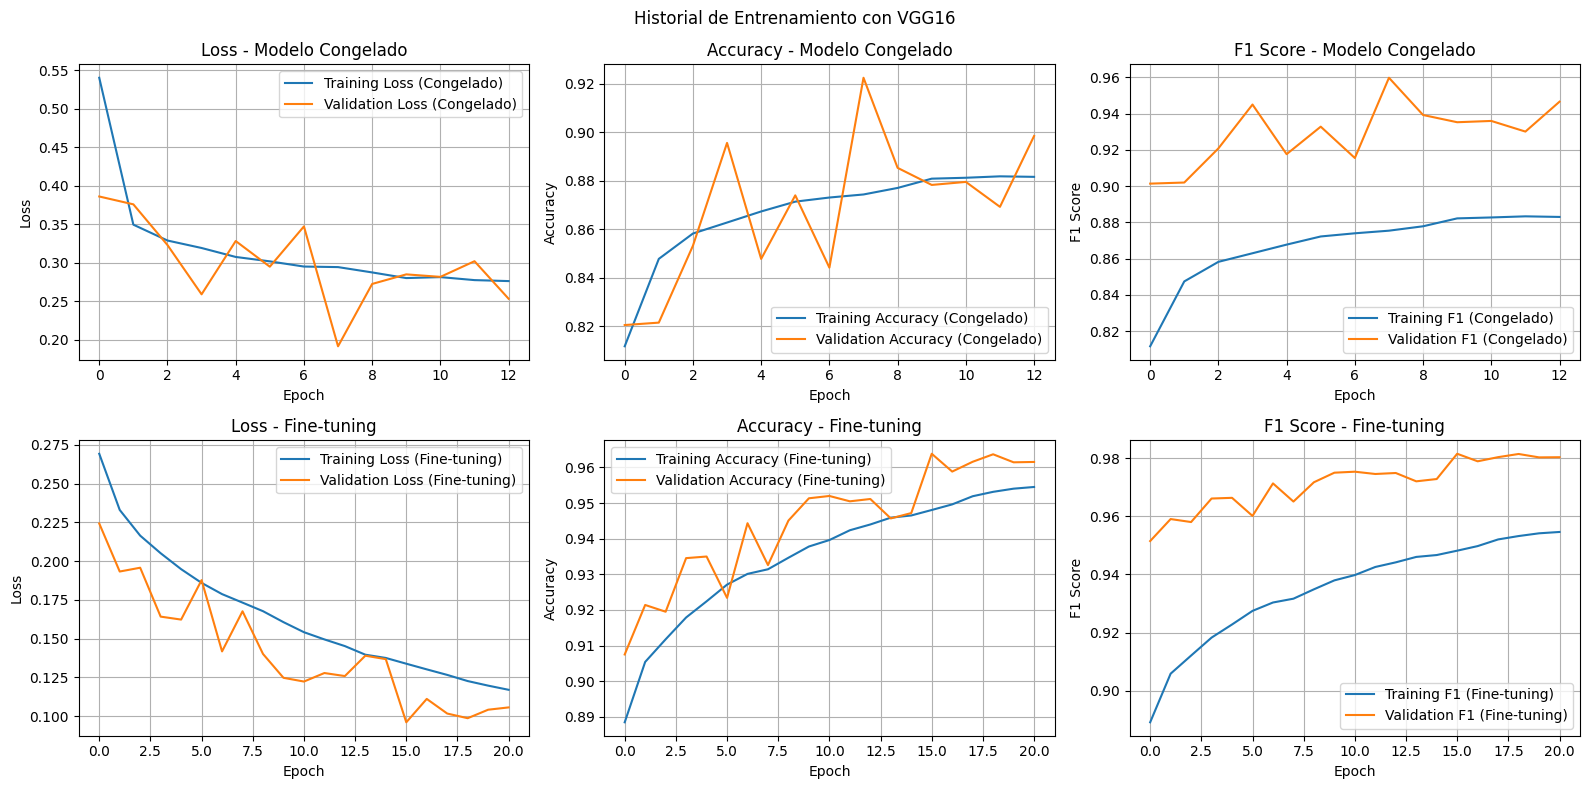

In [43]:
# Graficar historial de entrenamiento
plt.figure(figsize=(16, 8))
plt.suptitle('Historial de Entrenamiento con VGG16')

# Primera fila: Entrenamiento con VGG16 Congelado
# Loss 
plt.subplot(2, 3, 1) 
plt.plot(history.history['loss'], label='Training Loss (Congelado)')
plt.plot(history.history['val_loss'], label='Validation Loss (Congelado)')
plt.title('Loss - Modelo Congelado')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(2, 3, 2) 
plt.plot(history.history['accuracy'], label='Training Accuracy (Congelado)')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy (Congelado)')
plt.title('Accuracy - Modelo Congelado')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# F1 Score 
plt.subplot(2, 3, 3) 
plt.plot(history.history['f1_score'], label='Training F1 (Congelado)')
plt.plot(history.history['val_f1_score'], label='Validation F1 (Congelado)')
plt.title('F1 Score - Modelo Congelado')
plt.xlabel('Epoch')
plt.ylabel('F1 Score') 
plt.legend()
plt.grid(True)

# Segunda fila: Entrenamiento con VGG16 Descongelado

# Loss 
plt.subplot(2, 3, 4) 
plt.plot(history_unfrozen.history['loss'], label='Training Loss (Fine-tuning)')
plt.plot(history_unfrozen.history['val_loss'], label='Validation Loss (Fine-tuning)')
plt.title('Loss - Fine-tuning')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy 
plt.subplot(2, 3, 5) 
plt.plot(history_unfrozen.history['accuracy'], label='Training Accuracy (Fine-tuning)')
plt.plot(history_unfrozen.history['val_accuracy'], label='Validation Accuracy (Fine-tuning)')
plt.title('Accuracy - Fine-tuning')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# F1 Score 
plt.subplot(2, 3, 6) 
plt.plot(history_unfrozen.history['f1_score'], label='Training F1 (Fine-tuning)')
plt.plot(history_unfrozen.history['val_f1_score'], label='Validation F1 (Fine-tuning)')
plt.title('F1 Score - Fine-tuning')
plt.xlabel('Epoch')
plt.ylabel('F1 Score') 
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('historial_entrenamiento_inception_combinado.png')
plt.show()

## 5. Hacer predicciones en el conjunto de prueba

In [10]:
test_path = os.path.join(FILE_PATH, 'test')

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_path,
    labels='inferred',
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='binary',
    shuffle=True,
    seed=42,
)
test_dataset = test_dataset.map(adapt_image_for_vgg16, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

model = models.load_model('VGG_CIFAKE.keras')

test_results = model.evaluate(validation_dataset, verbose=1)

Found 20000 files belonging to 2 classes.
313/313 ━━━━━━━━━━━━━━━━━━━━ 49s 144ms/step - accuracy: 0.9957 - f1_score: 0.9978 - loss: 0.0166


## 6. Visualizar predicciones

In [22]:
# Obtener imágenes y etiquetas de test_dataset
num_per_class = 21  # 21 imágenes por categoría (3 filas x 7 columnas)

# Listas separadas para cada clase desde el principio
fake_images = []
real_images = []
fake_labels = []
real_labels = []

# Recopilar imágenes del dataset de prueba, separando por clase real (ground truth)
for images, labels in test_dataset.take(10):  # Tomar suficientes batches para asegurar 21 de cada clase
    for i in range(len(images)):
        true_class = int(labels[i].numpy()[0])
        
        if true_class == 0 and len(fake_images) < num_per_class:  # FAKE
            fake_images.append(images[i].numpy())
            fake_labels.append(true_class)
        elif true_class == 1 and len(real_images) < num_per_class:  # REAL
            real_images.append(images[i].numpy())
            real_labels.append(true_class)
        
        # Salir si ya tenemos suficientes de ambas clases
        if len(fake_images) >= num_per_class and len(real_images) >= num_per_class:
            break
    
    if len(fake_images) >= num_per_class and len(real_images) >= num_per_class:
        break

print(f"Imágenes FAKE recopiladas: {len(fake_images)}")
print(f"Imágenes REAL recopiladas: {len(real_images)}")

Imágenes FAKE recopiladas: 21
Imágenes REAL recopiladas: 21


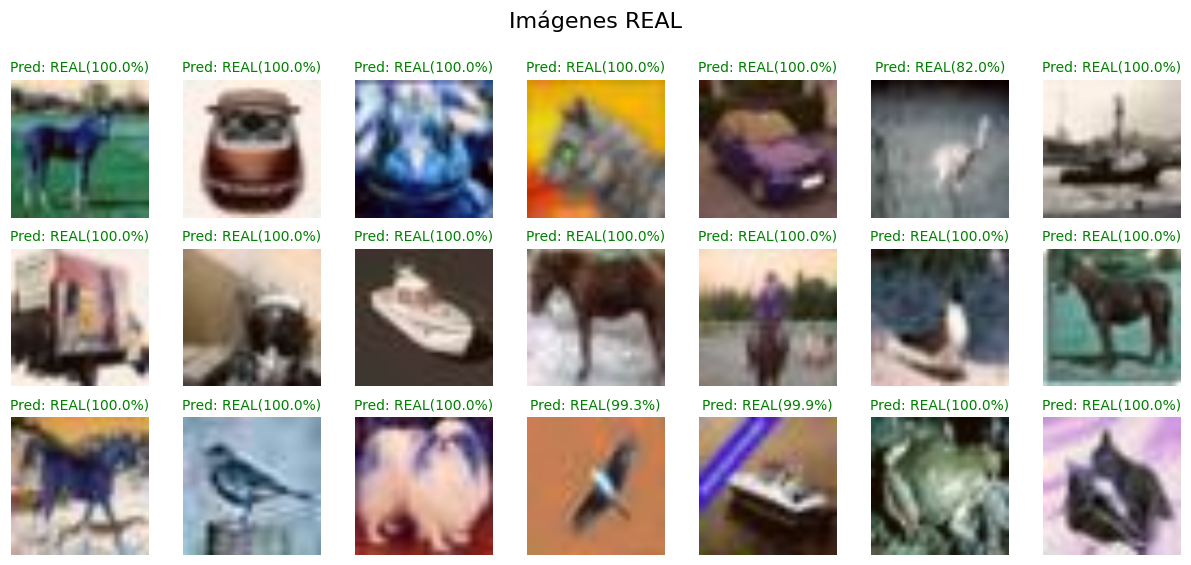

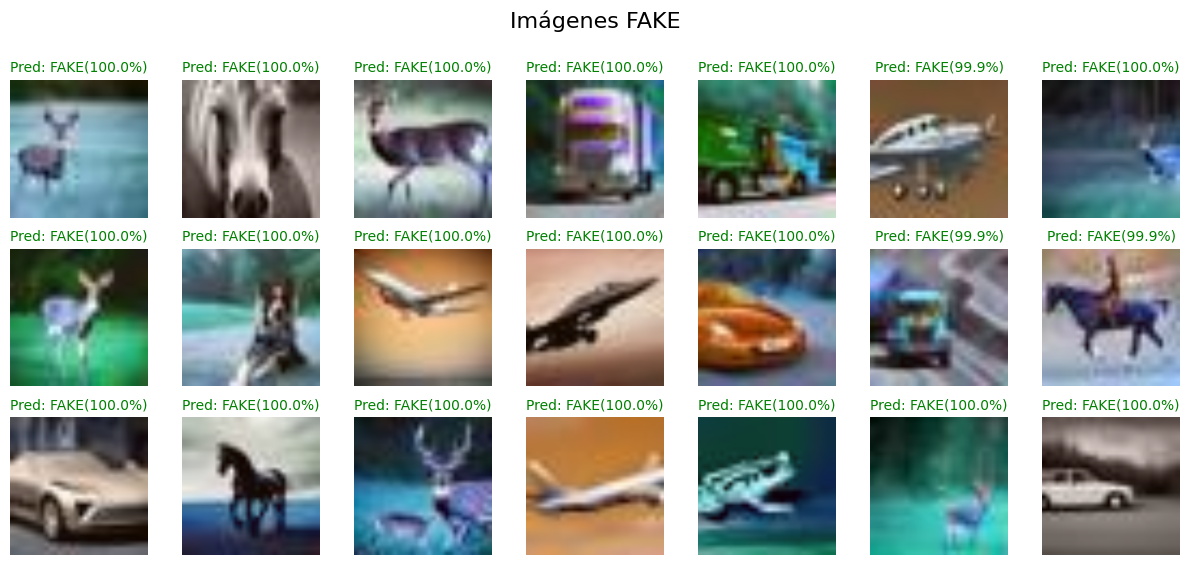


Métricas en la muestra visualizada:
Total de imágenes analizadas: 42
Imágenes FAKE: 21, Imágenes REAL: 21
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 score: 1.0000

Matriz de confusión:
[[TN, FP], [FN, TP]]
[[21  0]
 [ 0 21]]


In [ ]:
# Realizar predicciones para cada conjunto
fake_predictions = model.predict(np.array(fake_images), verbose=0)
fake_predictions = fake_predictions.flatten()
fake_pred_classes = (fake_predictions > 0.5).astype(int)

real_predictions = model.predict(np.array(real_images), verbose=0)
real_predictions = real_predictions.flatten()
real_pred_classes = (real_predictions > 0.5).astype(int)

# Visualizar imágenes REAL (3 filas x 7 columnas)
plt.figure(figsize=(12, 6))
plt.suptitle('Imágenes REAL', fontsize=16, y=0.95)

for i in range(len(real_images)):
    plt.subplot(3, 7, i+1)
    plt.imshow(array_to_img(real_images[i]))
    
    true_class = 'REAL'
    pred_class = ['FAKE', 'REAL'][real_pred_classes[i]]
    confidence = real_predictions[i] * 100 if real_pred_classes[i] == 1 else (1 - real_predictions[i]) * 100
    
    color = 'green' if true_class == pred_class else 'red'
    plt.title(f"Pred: {pred_class}({confidence:.1f}%)", color=color, fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.85, wspace=0.25)
plt.show()

# Visualizar imágenes FAKE (3 filas x 7 columnas)
plt.figure(figsize=(12, 6))
plt.suptitle('Imágenes FAKE', fontsize=16, y=0.95)

for i in range(len(fake_images)):
    plt.subplot(3, 7, i+1)
    plt.imshow(array_to_img(fake_images[i]))
    
    true_class = 'FAKE'
    pred_class = ['FAKE', 'REAL'][fake_pred_classes[i]]
    confidence = fake_predictions[i] * 100 if fake_pred_classes[i] == 1 else (1 - fake_predictions[i]) * 100
    
    color = 'green' if true_class == pred_class else 'red'
    plt.title(f"Pred: {pred_class}({confidence:.1f}%)", color=color, fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.85, wspace=0.25)
plt.show()


# Calcular métricas de rendimiento usando todas las imágenes recopiladas
all_labels = fake_labels + real_labels
all_pred_classes = fake_pred_classes.tolist() + real_pred_classes.tolist()

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

accuracy = accuracy_score(all_labels, all_pred_classes)
precision = precision_score(all_labels, all_pred_classes, average='binary')
recall = recall_score(all_labels, all_pred_classes, average='binary')
f1 = f1_score(all_labels, all_pred_classes, average='binary')
conf_matrix = confusion_matrix(all_labels, all_pred_classes)

print(f"\nMétricas en la muestra visualizada:")
print(f"Total de imágenes analizadas: {len(all_labels)}")
print(f"Imágenes FAKE: {len(fake_images)}, Imágenes REAL: {len(real_images)}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 score: {f1:.4f}")
print(f"\nMatriz de confusión:")
print(f"[[TN, FP], \n[FN, TP]]")
print(conf_matrix)

# Explicabilidad del Modelo

In [24]:
# Cargamos las imagenes seleccionadas del dataset de prueba
images = real_images[:num_per_class] + fake_images[:num_per_class]

# Crear un lote único con todas las imágenes ordenadas
images = np.stack(images, axis=0)

## GradCAM

In [ ]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import BinaryScore 
from tf_keras_vis.gradcam import Gradcam
from matplotlib import cm

# Número de imágenes por clase
num_per_class = 21

# --- Preparación para Grad-CAM ---
# Combinar las listas en el orden deseado: REAL primero, FAKE después
images_ordered = real_images + fake_images

# Crear un lote único con todas las imágenes ordenadas
images = np.stack(images_ordered, axis=0)

# Hacer predicciones para obtener las clases predichas
predictions = model.predict(images, verbose=0)
predicted_classes = ['REAL' if pred[0] >= 0.5 else 'FAKE' for pred in predictions]

# --- Generación de Grad-CAM ---
replace2linear = ReplaceToLinear()
score = BinaryScore(target_values=1)

gradcam = Gradcam(
    model,
    model_modifier=replace2linear,
    clone=True
)

# Generar Grad-CAM para las imágenes
cam = gradcam(
    score,
    images,
    penultimate_layer=-1
)


# --- Visualizar imágenes REAL con GradCAM (3 filas x 7 columnas) ---
plt.figure(figsize=(12, 6))
plt.suptitle('Imágenes REAL  - GradCAM', fontsize=16, y=0.98)

for i in range(num_per_class):
    plt.subplot(3, 7, i+1)
    
    # Convertir el mapa de calor a un formato adecuado para la visualización
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    
    plt.imshow(array_to_img(images[i]))
    plt.imshow(heatmap, cmap='jet', alpha=0.5)
    
    plt.title(f"Imagen {i} (Pred: {predicted_classes[i]})", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.85, wspace=0.25)
plt.show()


# --- Visualizar imágenes FAKE con GradCAM (3 filas x 7 columnas) ---
plt.figure(figsize=(12, 6))
plt.suptitle('Imágenes FAKE - GradCAM', fontsize=16, y=0.98)

for i in range(num_per_class, 2 * num_per_class):
    plt.subplot(3, 7, i-num_per_class+1)
    
    # Convertir el mapa de calor a un formato adecuado para la visualización
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    
    plt.imshow(array_to_img(images[i]))
    plt.imshow(heatmap, cmap='jet', alpha=0.5)
    
    plt.title(f"Imagen {i} (Pred: {predicted_classes[i]})", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.85, wspace=0.2)
plt.show()

## SmoothGrad

In [ ]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.saliency import Saliency
import gc

replace2linear = ReplaceToLinear()

score = CategoricalScore(0)

# Crear el objeto Saliency
saliency_vis = Saliency(model, model_modifier=replace2linear, clone=True)

# Process one image at a time
saliency_maps = []

for i, single_image in enumerate(images):
    
    # Add batch dimension
    image_batch = np.expand_dims(single_image, axis=0)
    
    single_saliency = saliency_vis(
        score,
        image_batch,
        smooth_samples=50, 
        smooth_noise=0.15
    )
    
    saliency_maps.append(single_saliency[0])
    
    # Clear memory
    del single_saliency, image_batch
    gc.collect()

saliency_map = np.array(saliency_maps)

# --- Visualizar imágenes REAL con SmoothGrad tf-keras-vis (3 filas x 7 columnas) ---
plt.figure(figsize=(12, 6))
plt.suptitle('Imágenes REAL - SmoothGrad (tf-keras-vis)', fontsize=16, y=0.98)

for i in range(num_per_class):
    ax = plt.subplot(3, 7, i+1)
    ax.imshow(saliency_map[i], cmap='jet')
    ax.set_title(f"Imagen {i} (Pred: {predicted_classes[i]})", fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.85, wspace=0.25)
plt.show()

# --- Visualizar imágenes FAKE con SmoothGrad tf-keras-vis (3 filas x 7 columnas) ---
plt.figure(figsize=(12, 6))
plt.suptitle('Imágenes FAKE - SmoothGrad (tf-keras-vis)', fontsize=16, y=0.98)

for i in range(num_per_class, 2 * num_per_class):
    ax = plt.subplot(3, 7, i-num_per_class+1)
    ax.imshow(saliency_map[i], cmap='jet')
    ax.set_title(f"Imagen {i} (Pred: {predicted_classes[i]})", fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.85, wspace=0.2)
plt.show()